<h1> Cuda verification </h1>

In [19]:
import torch

print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

12.8
NVIDIA GeForce RTX 4060 Laptop GPU


<h1>Augmentation pipeline </h1>

In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

training_pipeline = A.Compose([

    A.Resize(height=224, width=224),
    A.RandomCrop(height=180, width=180, p=1.0),
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.4),

    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), p=0.4),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.4),

    A.OneOf([
        A.GaussNoise(std_range=(0.1, 0.2), per_channel=True, p=0.4),
        A.RandomRain(slant_range=(-15, 15), drop_length=15, drop_width=1, rain_type="default", blur_value=7, p=0.4),
        A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(0.1, 0.25), hole_width_range=(0.1, 0.25), fill=0, p=0.4)
    ], p=0.5),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

basic_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.6),
    A.Rotate(limit=(-45,45), p=0.7),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

<h2>Data preparation</h2>

In [22]:
import random
import shutil
from pathlib import Path

def prepare_image_datasets(source_dir, base_dir, split_ratios=(0.7, 0.2, 0.1)):

     if not (0.999 < sum(split_ratios) < 1.001):
             raise ValueError('split_ratios must sum to 1')

     source_path = Path(source_dir)
     base_path = Path(base_dir)

     if not source_path.is_dir():
         print(f'Source directory {source_path.name} does not exist')
         return

     train_path = base_path / 'train'
     test_path = base_path / 'test'
     val_path = base_path / 'val'

     class_names = [d.name for d in source_path.iterdir() if d.is_dir()]

     if not class_names:
         print(f'Source directory {source_path.name} does not contain any class names')
         return

     for directory in [train_path, test_path, val_path]:
         for class_name in class_names:
             (directory / class_name).mkdir(parents=True, exist_ok=True)

     for class_name in class_names:

         class_source_path = source_path / class_name

         files = [f for f in class_source_path.iterdir() if f.is_file()]

         random.shuffle(files)

         total_files = len(files)
         train_end = int(total_files * split_ratios[0])
         test_end = train_end + int(total_files * split_ratios[1])

         split_data = {
             'train': (files[:train_end], train_path),
             'test': (files[train_end:test_end], test_path),
             'val': (files[test_end:], val_path)
         }

         print(f"Copying {class_name} to {base_path}")

         for split_name, (file_list, destination_path) in split_data.items():

             dest_class_path = destination_path / class_name

             for file_path in tqdm(file_list, desc=f'Copying {split_name} files'):

                 shutil.copy2(file_path, dest_class_path / file_path.name)

         print(f'Copying {class_name} finished!')

     print("Data splitting successful!")


In [23]:
import cv2
from torchvision import datasets

class CustomDataset(datasets.ImageFolder):

    def __getitem__(self, index):

        path, target = self.samples[index]

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, target

    def __len__(self):
        return len(self.samples)

# data = CustomDataset(root='dataset', transform=training_pipeline)

# image, path = data[0]
#
# print(path)
#
# image = image.permute(1,2,0).numpy()
#
# image = (image * np
#          .array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
# image = np.clip(image, 0, 1)
# image = (image * 255).astype(np.uint8)
#
# plt.imshow(image)
# plt.show()

<h2> Data splitting </h2>

In [6]:
source_data_dir = r'C:\Users\LANCE\OneDrive\Desktop\rice_pest\Finalized_datasets'
base_data_dir = r'C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets'

if not source_data_dir or not base_data_dir:
    raise ValueError('Source and base data directory not found')

prepare_image_datasets(source_data_dir, base_data_dir, split_ratios=(0.7, 0.2, 0.1))


Copying brown-planthopper to C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets


Copying val files: 100%|██████████| 246/246 [00:00<00:00, 1087.34it/s]


Copying brown-planthopper finished!
Copying green-leafhopper to C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets


Copying val files: 100%|██████████| 215/215 [00:00<00:00, 1213.62it/s]


Copying green-leafhopper finished!
Copying rice-black-bug to C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets


Copying val files: 100%|██████████| 16/16 [00:00<00:00, 913.85it/s]


Copying rice-black-bug finished!
Copying rice-leaf-folder to C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets


Copying val files: 100%|██████████| 275/275 [00:00<00:00, 1070.15it/s]


Copying rice-leaf-folder finished!
Copying stem-borer to C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets


Copying val files: 100%|██████████| 197/197 [00:00<00:00, 923.07it/s] 


Copying stem-borer finished!
Copying whorl-maggot to C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets


Copying val files: 100%|██████████| 125/125 [00:00<00:00, 1097.27it/s]

Copying whorl-maggot finished!
Data splitting successful!


<h2> Training functions and hyperparameters</h2>

In [24]:
import torch.nn as nn
import torch.nn.functional as F
import math

class LSoftmax(nn.Module):

    def __init__(self, input_features, number_of_classes, m=3):
        super(LSoftmax, self).__init__()
        self.input_features = input_features
        self.number_of_classes = number_of_classes
        self.m = m

        if m <= 1:
            raise ValueError('m must be greater than 1')

        # Initialization of weights through xavier uniform.
        self.weight = nn.Parameter(torch.FloatTensor(number_of_classes,  input_features))
        nn.init.xavier_uniform_(self.weight)

    # Forward propagation
    def forward(self, x, labels=None):

        # normalization of weights and input vector features.
        normalize_weight = F.normalize(self.weight, p=2, dim=1)
        normalize_x = F.normalize(x, p=2, dim=1)

        # Cosine similarity: perform DOT product multiplication between weights and input vectors.
        # cos_theta = F.linear(normalize_x, normalize_weight.t())

        cos_theta = F.linear(normalize_x, normalize_weight)
        if labels is None:
            return cos_theta

        cos_theta = cos_theta.clamp(-1,1)

        # Convert cosine similarity into actual angles.
        theta = torch.acos(cos_theta)

        # Gathered the correct classes as one vector and reshape it in to a 2d with one column.
        target_theta = theta.gather(1, labels.view(-1,1))

        # applies the margin to the correct classes
        m_theta = self.m * target_theta
        k = (m_theta / math.pi).floor()

        # Compute the angular margin to get a new hard target score for prediction
        psi_theta = ((-1)**k) * torch.cos(m_theta) - (2*k)

        # Scattered the new values got from psi_theta to its corresponding classes
        final_logits = cos_theta.scatter(1, labels.view(-1,1), psi_theta)

        return final_logits


In [35]:
import torchvision.models as models

class PestClassifierMobileNetV2(nn.Module):

    def __init__(self, num_classes, margin):
        super(PestClassifierMobileNetV2, self).__init__()

        # get model
        self.base_model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

        # Froze feature extraction layer to retain weights.
        for params in self.base_model.parameters():
            params.requires_grad = False

        # get number of features
        num_filters = self.base_model.classifier[1].in_features

        # Hyperparameter tuning: Instantiate LSoftmax as new customized final layer.
        self.base_model.classifier = nn.Sequential(

            #added dropout layer
            nn.Dropout(p=0.4, inplace=True),
            LSoftmax(
                input_features=num_filters,
                number_of_classes=num_classes,
                m=margin
            )
    )

    # Forward propagation
    def forward(self, x, labels=None):

        # Passed the features in feature extraction layer.
        features = self.base_model.features(x)

        # Adaptive average pooling: returns a 2d scaled vector features.
        features = F.adaptive_avg_pool2d(features, (1,1)).reshape(features.shape[0], -1)

        if labels is None:
            #For inference
            return self.base_model.classifier(features)

        else:

            # passing to dropout
            features = self.base_model.classifier[0](features)
            # Implementation of the LSoftmax through passing the feature vectors and class for classification.
            logits = self.base_model.classifier[1](features, labels)

        # return the result logits
        return logits

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")
            return

        print(f"\nUnfreezing feature layer at index: -{layer}")

        for param in self.base_model.features[-layer].parameters():
            param.requires_grad = True


In [107]:
class PestClassifierEffecientNetv2M(nn.Module):
    def __init__(self, num_classes, margin):
        super(PestClassifierEffecientNetv2M, self).__init__()

        self.base_model = models.efficientnet_v2_m(weights='EfficientNet_V2_Weights.IMAGENET1K_V2')

        for params in self.model.parameters():
            params.requires_grad = False

        num_filters = self.base_model.classifier[1].in_features

        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            LSoftmax(
                input_features=num_filters,
                number_of_classes=num_classes,
                m=margin
            )
        )

        def forward(self, x, labels=None):
            features = self.base_model.features(x)

In [104]:
model = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.IMAGENET1K_V1')

print(model.classifier)

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [32]:
from tqdm import tqdm

def train_and_test(model, optimizer, criterion, train_dataloader, test_dataloader, num_epoch, device, best_accuracy = 0.0):

    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(num_epoch):
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}")
        for data, labels in train_pbar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data, labels)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        training_loss = running_train_loss / len(train_dataloader)
        train_losses.append(training_loss)

        model.eval()
        running_test_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_dataloader, desc=f"Test epoch: {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                output_loss = model(inputs, labels)
                loss = criterion(output_loss, labels)
                running_test_loss += loss.item()

                output_predictions = model(inputs, labels=None)
                _, predicted = torch.max(output_predictions.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        testing_loss = running_test_loss / len(test_dataloader)
        test_losses.append(testing_loss)
        accuracy = 100 * correct_predictions / total_samples
        accuracies.append(accuracy)

        epoch_summary = f'Epoch {epoch+1}/{num_epoch} | Train Loss: {training_loss:.4f} | Test Loss: {testing_loss:.4f} | Accuracy: {accuracy:.2f}%'

        if device.type == 'cuda':
            allocated_gb = torch.cuda.memory_allocated() / (1024 ** 3)
            reserved_gb = torch.cuda.memory_reserved() / (1024 ** 3)
            epoch_summary += f' | GPU Memory (Alloc/Reserved): {allocated_gb:.2f}/{reserved_gb:.2f} GB'

        tqdm.write(epoch_summary)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'models/MobileNetV2/v2/Advance/MobileNetV2_rice_pest_classificationV7.pt')

    tqdm.write('Phase done!')

    return {'train_loss': train_losses, 'test_loss': test_losses, 'accuracy': accuracies}, best_accuracy

<h3> Data loader </h3>

In [31]:
from torch.utils.data import DataLoader

train_set = CustomDataset(root='datasets/train', transform=training_pipeline)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_set = CustomDataset(root='datasets/test', transform=validation_pipeline)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)
validation_set = CustomDataset(root='datasets/val', transform=validation_pipeline)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=True)

classes = train_set.classes

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def plot_training_result(*results):

    full_training_loss = []
    full_test_loss = []

    for result in results:
        train_loss = result.get('train_loss', [])
        full_training_loss.extend(train_loss)
        full_test_loss.extend(result.get('test_loss', []))

    total_epochs = len(full_training_loss)

    if total_epochs == 0:
        print("No data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    data = {
        'Epoch': epochs,
        'Training Loss': full_training_loss,
        'Testing Loss': full_test_loss,
    }

    df = pd.DataFrame(data)

    df_long = df.melt(id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long, x='Epoch', y='Loss', hue='Loss Type', marker='o')

    plt.title('Training and Testing Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(*results):

    full_accuracy = []

    for res in results:
        accuracy = res.get('accuracy', [])
        full_accuracy.extend(accuracy)

    total_epochs = len(full_accuracy)

    if total_epochs == 0:
        print("No accuracy data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, full_accuracy, label='Accuracy', marker='o', color='g')

    plt.title('Accuracy Evaluation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy_per_session(session_accuracies):

    total_sessions = len(session_accuracies)
    if total_sessions == 0: return
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, total_sessions + 1), session_accuracies, label='Best Session Accuracy', marker='o', color='r')
    plt.title('Best Accuracy per Training Session')
    plt.xlabel('Training Session')
    plt.ylabel('Best Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_historical_data(*histories, filename='training_results/v2/MobileNetV2_rice_pest_classificationV7.csv'):

    full_train_loss = []
    full_test_loss = []
    full_accuracy = []

    for history in histories:

        full_train_loss.extend(history.get('train_loss', []))
        full_test_loss.extend(history.get('test_loss', []))
        full_accuracy.extend(history.get('accuracy', []))

    data_dict = pd.DataFrame({
        'train_loss': full_train_loss,
        'test_loss': full_test_loss,
        'accuracy': full_accuracy,
    })

    if os.path.exists(filename):
        print("historical data exists! Appending new data.")

        old_data = pd.read_csv(filename)
        combined_data = pd.concat([old_data, data_dict], ignore_index=True)

    else:
        print("Creating new historical data...")
        combined_data = data_dict

    combined_data['epoch'] = range(1, len(combined_data) + 1)

    combined_data = combined_data[['epoch', 'train_loss', 'test_loss', 'accuracy']]

    combined_data.to_csv(filename, index=False)

    print("Historical data saved successfully!")


In [29]:
def incremental_training(model, sessions, criterion, train_dataloader, test_dataloader, device):

    full_history = []
    session_best_accuracies = []
    best_overall_accuracy = 0.0

    for i, session in enumerate(sessions):
        print(f"\n--- Starting Training Session {i+1}/{len(sessions)} ---")

        epochs = session['epochs']
        lr = session['lr']
        layer_to_unfreeze = session.get('unfreeze_layer', 0)

        if layer_to_unfreeze > 0:
            model.unfreeze_layer(layer_to_unfreeze)

        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-2)

        session_history, best_overall_accuracy = train_and_test(
            model, optimizer, criterion, train_dataloader, test_dataloader, epochs, device, best_accuracy=best_overall_accuracy
        )

        full_history.append(session_history)

        if session_history['accuracy']:
            best_in_session = max(session_history['accuracy'])
            session_best_accuracies.append(best_in_session)

    return full_history, session_best_accuracies

Phase 1


Test epoch: 1: 100%|██████████| 34/34 [00:07<00:00,  4.74it/s]


Epoch 1/15 | Train Loss: 3.1965 | Test Loss: 3.0356 | Accuracy: 39.35% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 2: 100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


Epoch 2/15 | Train Loss: 3.0200 | Test Loss: 3.0007 | Accuracy: 50.33% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 3: 100%|██████████| 34/34 [00:05<00:00,  5.76it/s]


Epoch 3/15 | Train Loss: 3.0033 | Test Loss: 2.9876 | Accuracy: 58.68% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 4: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 4/15 | Train Loss: 2.9959 | Test Loss: 2.9729 | Accuracy: 63.09% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 5: 100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


Epoch 5/15 | Train Loss: 2.9906 | Test Loss: 2.9662 | Accuracy: 64.26% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 6: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 6/15 | Train Loss: 2.9874 | Test Loss: 2.9590 | Accuracy: 65.48% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 7: 100%|██████████| 34/34 [00:05<00:00,  5.75it/s]


Epoch 7/15 | Train Loss: 2.9845 | Test Loss: 2.9570 | Accuracy: 65.24% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 8: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 8/15 | Train Loss: 2.9845 | Test Loss: 2.9530 | Accuracy: 66.84% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 9: 100%|██████████| 34/34 [00:06<00:00,  5.57it/s]


Epoch 9/15 | Train Loss: 2.9827 | Test Loss: 2.9556 | Accuracy: 65.99% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 10: 100%|██████████| 34/34 [00:05<00:00,  5.76it/s]


Epoch 10/15 | Train Loss: 2.9831 | Test Loss: 2.9491 | Accuracy: 67.68% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 11: 100%|██████████| 34/34 [00:05<00:00,  5.75it/s]


Epoch 11/15 | Train Loss: 2.9816 | Test Loss: 2.9521 | Accuracy: 65.99% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 12: 100%|██████████| 34/34 [00:05<00:00,  5.69it/s]


Epoch 12/15 | Train Loss: 2.9806 | Test Loss: 2.9490 | Accuracy: 69.61% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 13: 100%|██████████| 34/34 [00:06<00:00,  5.27it/s]


Epoch 13/15 | Train Loss: 2.9813 | Test Loss: 2.9501 | Accuracy: 69.89% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 14: 100%|██████████| 34/34 [00:05<00:00,  5.71it/s]


Epoch 14/15 | Train Loss: 2.9812 | Test Loss: 2.9489 | Accuracy: 67.26% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 15: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch 15/15 | Train Loss: 2.9803 | Test Loss: 2.9480 | Accuracy: 66.51% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB
Training done!
Phase 2

Unfreezing the last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:05<00:00,  5.72it/s]


Epoch 1/30 | Train Loss: 2.9773 | Test Loss: 2.9368 | Accuracy: 69.37% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 2: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 2/30 | Train Loss: 2.9729 | Test Loss: 2.9264 | Accuracy: 71.06% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 3: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 3/30 | Train Loss: 2.9674 | Test Loss: 2.9175 | Accuracy: 72.80% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 4: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Epoch 4/30 | Train Loss: 2.9626 | Test Loss: 2.9077 | Accuracy: 73.22% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 5: 100%|██████████| 34/34 [00:05<00:00,  5.79it/s]


Epoch 5/30 | Train Loss: 2.9576 | Test Loss: 2.8955 | Accuracy: 73.50% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 6: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Epoch 6/30 | Train Loss: 2.9527 | Test Loss: 2.8862 | Accuracy: 74.25% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 7: 100%|██████████| 34/34 [00:05<00:00,  5.76it/s]


Epoch 7/30 | Train Loss: 2.9489 | Test Loss: 2.8784 | Accuracy: 74.39% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 8: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Epoch 8/30 | Train Loss: 2.9440 | Test Loss: 2.8653 | Accuracy: 74.77% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 9: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]


Epoch 9/30 | Train Loss: 2.9374 | Test Loss: 2.8565 | Accuracy: 74.67% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 10: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch 10/30 | Train Loss: 2.9309 | Test Loss: 2.8393 | Accuracy: 73.64% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 11: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]


Epoch 11/30 | Train Loss: 2.9280 | Test Loss: 2.8213 | Accuracy: 72.75% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 12: 100%|██████████| 34/34 [00:05<00:00,  5.70it/s]


Epoch 12/30 | Train Loss: 2.9164 | Test Loss: 2.7966 | Accuracy: 72.14% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 13: 100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


Epoch 13/30 | Train Loss: 2.9075 | Test Loss: 2.7723 | Accuracy: 71.81% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 14: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch 14/30 | Train Loss: 2.8926 | Test Loss: 2.7412 | Accuracy: 70.64% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 15: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 15/30 | Train Loss: 2.8841 | Test Loss: 2.7116 | Accuracy: 69.23% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 16: 100%|██████████| 34/34 [00:06<00:00,  5.44it/s]


Epoch 16/30 | Train Loss: 2.8703 | Test Loss: 2.6805 | Accuracy: 70.22% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 17: 100%|██████████| 34/34 [00:05<00:00,  5.68it/s]


Epoch 17/30 | Train Loss: 2.8568 | Test Loss: 2.6478 | Accuracy: 68.71% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 18: 100%|██████████| 34/34 [00:08<00:00,  4.14it/s]


Epoch 18/30 | Train Loss: 2.8443 | Test Loss: 2.6116 | Accuracy: 69.18% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 19: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch 19/30 | Train Loss: 2.8289 | Test Loss: 2.5813 | Accuracy: 68.86% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 20: 100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


Epoch 20/30 | Train Loss: 2.8152 | Test Loss: 2.5441 | Accuracy: 68.95% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 21: 100%|██████████| 34/34 [00:06<00:00,  5.66it/s]


Epoch 21/30 | Train Loss: 2.8003 | Test Loss: 2.5018 | Accuracy: 69.18% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 22: 100%|██████████| 34/34 [00:05<00:00,  5.69it/s]


Epoch 22/30 | Train Loss: 2.7798 | Test Loss: 2.4603 | Accuracy: 69.47% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 23: 100%|██████████| 34/34 [00:06<00:00,  5.57it/s]


Epoch 23/30 | Train Loss: 2.7595 | Test Loss: 2.4284 | Accuracy: 69.65% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 24: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]


Epoch 24/30 | Train Loss: 2.7457 | Test Loss: 2.3764 | Accuracy: 70.31% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 25: 100%|██████████| 34/34 [00:06<00:00,  5.65it/s]


Epoch 25/30 | Train Loss: 2.7192 | Test Loss: 2.3437 | Accuracy: 71.15% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 26: 100%|██████████| 34/34 [00:05<00:00,  5.71it/s]


Epoch 26/30 | Train Loss: 2.6975 | Test Loss: 2.3125 | Accuracy: 70.97% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 27: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 27/30 | Train Loss: 2.6874 | Test Loss: 2.2825 | Accuracy: 70.92% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 28: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 28/30 | Train Loss: 2.6706 | Test Loss: 2.2525 | Accuracy: 70.97% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 29: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 29/30 | Train Loss: 2.6527 | Test Loss: 2.2320 | Accuracy: 70.83% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 30: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 30/30 | Train Loss: 2.6292 | Test Loss: 2.2074 | Accuracy: 71.11% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB
Training done!
Phase 3

Unfreezing the before last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 1/45 | Train Loss: 2.5817 | Test Loss: 2.1385 | Accuracy: 71.34% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 2: 100%|██████████| 34/34 [00:06<00:00,  5.38it/s]


Epoch 2/45 | Train Loss: 2.5154 | Test Loss: 2.0587 | Accuracy: 72.80% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 3: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 3/45 | Train Loss: 2.4439 | Test Loss: 1.9947 | Accuracy: 74.16% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 4: 100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


Epoch 4/45 | Train Loss: 2.4089 | Test Loss: 1.9541 | Accuracy: 74.67% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 5: 100%|██████████| 34/34 [00:06<00:00,  5.51it/s]


Epoch 5/45 | Train Loss: 2.3701 | Test Loss: 1.9163 | Accuracy: 75.52% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 6: 100%|██████████| 34/34 [00:06<00:00,  5.43it/s]


Epoch 6/45 | Train Loss: 2.3469 | Test Loss: 1.8799 | Accuracy: 75.52% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 7: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 7/45 | Train Loss: 2.3042 | Test Loss: 1.8586 | Accuracy: 75.47% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 8: 100%|██████████| 34/34 [00:06<00:00,  5.46it/s]


Epoch 8/45 | Train Loss: 2.2861 | Test Loss: 1.8393 | Accuracy: 76.17% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 9: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 9/45 | Train Loss: 2.2615 | Test Loss: 1.8153 | Accuracy: 77.30% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 10: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 10/45 | Train Loss: 2.2557 | Test Loss: 1.8018 | Accuracy: 78.24% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 11: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 11/45 | Train Loss: 2.2289 | Test Loss: 1.7830 | Accuracy: 78.10% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 12: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 12/45 | Train Loss: 2.2186 | Test Loss: 1.7713 | Accuracy: 78.56% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 13: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch 13/45 | Train Loss: 2.1957 | Test Loss: 1.7611 | Accuracy: 79.22% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 14: 100%|██████████| 34/34 [00:06<00:00,  5.50it/s]


Epoch 14/45 | Train Loss: 2.1887 | Test Loss: 1.7566 | Accuracy: 79.08% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 15: 100%|██████████| 34/34 [00:06<00:00,  5.42it/s]


Epoch 15/45 | Train Loss: 2.1715 | Test Loss: 1.7314 | Accuracy: 79.55% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 16: 100%|██████████| 34/34 [00:06<00:00,  5.46it/s]


Epoch 16/45 | Train Loss: 2.1653 | Test Loss: 1.7184 | Accuracy: 80.21% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 17: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 17/45 | Train Loss: 2.1523 | Test Loss: 1.7067 | Accuracy: 80.82% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 18: 100%|██████████| 34/34 [00:06<00:00,  5.57it/s]


Epoch 18/45 | Train Loss: 2.1517 | Test Loss: 1.6960 | Accuracy: 81.33% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 19: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 19/45 | Train Loss: 2.1384 | Test Loss: 1.6866 | Accuracy: 81.71% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 20: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 20/45 | Train Loss: 2.1081 | Test Loss: 1.6606 | Accuracy: 82.55% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 21: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 21/45 | Train Loss: 2.1171 | Test Loss: 1.6606 | Accuracy: 82.27% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 22: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 22/45 | Train Loss: 2.1009 | Test Loss: 1.6404 | Accuracy: 83.35% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 23: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 23/45 | Train Loss: 2.0870 | Test Loss: 1.6344 | Accuracy: 83.16% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 24: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch 24/45 | Train Loss: 2.0840 | Test Loss: 1.6195 | Accuracy: 83.44% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 25: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 25/45 | Train Loss: 2.0824 | Test Loss: 1.6075 | Accuracy: 83.82% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 26: 100%|██████████| 34/34 [00:06<00:00,  5.48it/s]


Epoch 26/45 | Train Loss: 2.0750 | Test Loss: 1.5972 | Accuracy: 83.96% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 27: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Epoch 27/45 | Train Loss: 2.0677 | Test Loss: 1.5824 | Accuracy: 84.15% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 28: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 28/45 | Train Loss: 2.0635 | Test Loss: 1.5867 | Accuracy: 84.43% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 29: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 29/45 | Train Loss: 2.0307 | Test Loss: 1.5759 | Accuracy: 84.29% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 30: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 30/45 | Train Loss: 2.0414 | Test Loss: 1.5640 | Accuracy: 84.38% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 31: 100%|██████████| 34/34 [00:06<00:00,  5.37it/s]


Epoch 31/45 | Train Loss: 2.0414 | Test Loss: 1.5601 | Accuracy: 84.99% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 32: 100%|██████████| 34/34 [00:06<00:00,  5.36it/s]


Epoch 32/45 | Train Loss: 2.0426 | Test Loss: 1.5528 | Accuracy: 84.76% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 33: 100%|██████████| 34/34 [00:06<00:00,  5.51it/s]


Epoch 33/45 | Train Loss: 2.0295 | Test Loss: 1.5451 | Accuracy: 84.99% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 34: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 34/45 | Train Loss: 2.0143 | Test Loss: 1.5386 | Accuracy: 85.13% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 35: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 35/45 | Train Loss: 2.0048 | Test Loss: 1.5272 | Accuracy: 85.65% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 36: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 36/45 | Train Loss: 2.0030 | Test Loss: 1.5286 | Accuracy: 85.23% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 37: 100%|██████████| 34/34 [00:06<00:00,  5.39it/s]


Epoch 37/45 | Train Loss: 1.9899 | Test Loss: 1.5162 | Accuracy: 85.88% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 38: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 38/45 | Train Loss: 1.9878 | Test Loss: 1.5035 | Accuracy: 85.55% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 39: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch 39/45 | Train Loss: 1.9849 | Test Loss: 1.5101 | Accuracy: 85.65% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 40: 100%|██████████| 34/34 [00:06<00:00,  4.96it/s]


Epoch 40/45 | Train Loss: 1.9902 | Test Loss: 1.5024 | Accuracy: 85.74% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 41: 100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


Epoch 41/45 | Train Loss: 1.9901 | Test Loss: 1.4996 | Accuracy: 85.93% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 42: 100%|██████████| 34/34 [00:06<00:00,  5.27it/s]


Epoch 42/45 | Train Loss: 1.9852 | Test Loss: 1.5017 | Accuracy: 85.46% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 43: 100%|██████████| 34/34 [00:06<00:00,  5.34it/s]


Epoch 43/45 | Train Loss: 1.9817 | Test Loss: 1.4941 | Accuracy: 85.74% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 44: 100%|██████████| 34/34 [00:06<00:00,  5.45it/s]


Epoch 44/45 | Train Loss: 1.9656 | Test Loss: 1.4950 | Accuracy: 85.88% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 45: 100%|██████████| 34/34 [00:06<00:00,  5.48it/s]


Epoch 45/45 | Train Loss: 1.9857 | Test Loss: 1.4845 | Accuracy: 86.16% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB
Training done!


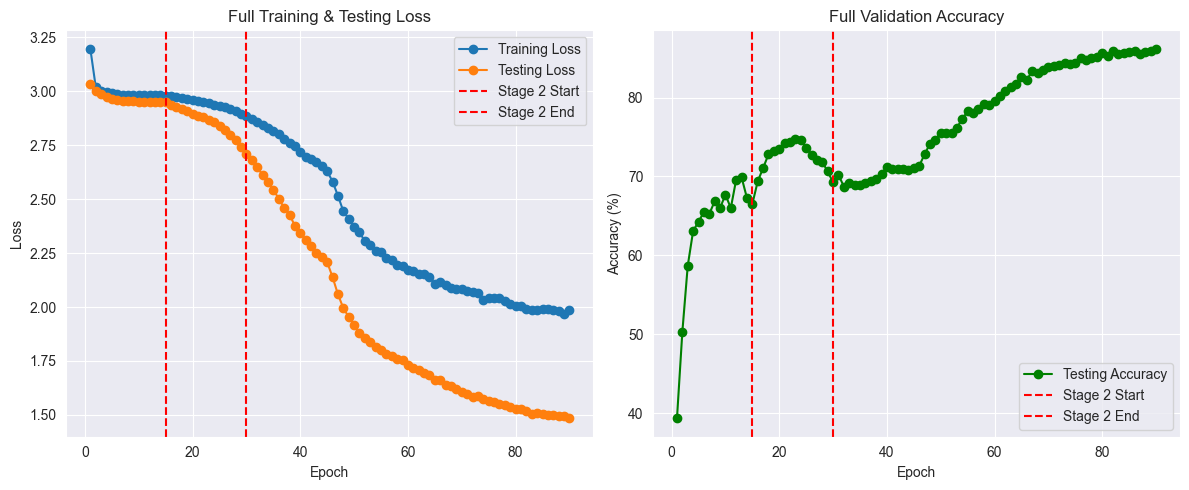

Data saved!


In [13]:
# import torch.optim as optim
#
# hardware = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# classes = 6
# weight_decay = 1e-2
# num_margin = 3
#
# model = PestClassifierMobileNetV2(num_classes=classes, margin=num_margin).to(hardware)
# criterion = nn.CrossEntropyLoss()
#
# optimizer_p1 = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=weight_decay)
# model.unfreeze_last_block()
# model.unfreeze_before_last_block()
#
# result_1, accuracy_p1 = train_and_test(model=model, optimizer=optimizer_p1, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=15, device=hardware)
#
# save_historical_data(result_1)

In [11]:
import torch

allocated_bytes = torch.cuda.memory_allocated('cuda')
allocated_mb = allocated_bytes / (1024 * 1024)

reserved_bytes = torch.cuda.memory_reserved('cuda')
reserved_mb = reserved_bytes / (1024 * 1024)

print("\n--- VRAM USAGE REPORT ---")
print(f"Memory Allocated: {allocated_mb:.2f} MB")
print(f"Memory Reserved:  {reserved_mb:.2f} MB")
print("-------------------------\n")



--- VRAM USAGE REPORT ---
Memory Allocated: 0.00 MB
Memory Reserved:  0.00 MB
-------------------------



<h2> V6 experimenation </h2>


Unfreezing the last convolutional block for fine-tuning...

Unfreezing the before last convolutional block for fine-tuning...

Unfreezing the third last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s]


Epoch 1/20 | Train Loss: 1.7617 | Test Loss: 1.5541 | Accuracy: 83.30% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 2: 100%|██████████| 34/34 [00:05<00:00,  5.91it/s]


Epoch 2/20 | Train Loss: 1.7279 | Test Loss: 1.5232 | Accuracy: 83.54% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 3: 100%|██████████| 34/34 [00:06<00:00,  5.12it/s]


Epoch 3/20 | Train Loss: 1.7032 | Test Loss: 1.4917 | Accuracy: 84.99% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 4: 100%|██████████| 34/34 [00:06<00:00,  5.48it/s]


Epoch 4/20 | Train Loss: 1.6836 | Test Loss: 1.4651 | Accuracy: 85.41% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 5: 100%|██████████| 34/34 [00:06<00:00,  5.42it/s]


Epoch 5/20 | Train Loss: 1.6431 | Test Loss: 1.4496 | Accuracy: 85.74% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 6: 100%|██████████| 34/34 [00:06<00:00,  5.50it/s]


Epoch 6/20 | Train Loss: 1.6227 | Test Loss: 1.4234 | Accuracy: 86.59% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 7: 100%|██████████| 34/34 [00:06<00:00,  5.64it/s]


Epoch 7/20 | Train Loss: 1.6146 | Test Loss: 1.4089 | Accuracy: 86.54% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 8: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 8/20 | Train Loss: 1.6007 | Test Loss: 1.4169 | Accuracy: 87.20% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 9: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 9/20 | Train Loss: 1.5834 | Test Loss: 1.3864 | Accuracy: 87.85% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 10: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 10/20 | Train Loss: 1.5724 | Test Loss: 1.3764 | Accuracy: 88.32% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 11: 100%|██████████| 34/34 [00:06<00:00,  5.64it/s]


Epoch 11/20 | Train Loss: 1.5450 | Test Loss: 1.3810 | Accuracy: 88.56% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 12: 100%|██████████| 34/34 [00:13<00:00,  2.49it/s]


Epoch 12/20 | Train Loss: 1.5419 | Test Loss: 1.3761 | Accuracy: 87.95% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 13: 100%|██████████| 34/34 [00:06<00:00,  5.63it/s]


Epoch 13/20 | Train Loss: 1.5447 | Test Loss: 1.3667 | Accuracy: 88.46% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 14: 100%|██████████| 34/34 [00:06<00:00,  5.63it/s]


Epoch 14/20 | Train Loss: 1.5338 | Test Loss: 1.3551 | Accuracy: 89.40% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 15: 100%|██████████| 34/34 [00:06<00:00,  5.64it/s]


Epoch 15/20 | Train Loss: 1.5086 | Test Loss: 1.3445 | Accuracy: 89.02% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 16: 100%|██████████| 34/34 [00:06<00:00,  5.63it/s]


Epoch 16/20 | Train Loss: 1.4951 | Test Loss: 1.3429 | Accuracy: 89.54% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 17: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Epoch 17/20 | Train Loss: 1.5030 | Test Loss: 1.3372 | Accuracy: 89.77% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 18: 100%|██████████| 34/34 [00:06<00:00,  5.65it/s]


Epoch 18/20 | Train Loss: 1.5056 | Test Loss: 1.3229 | Accuracy: 90.29% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 19: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch 19/20 | Train Loss: 1.4920 | Test Loss: 1.3300 | Accuracy: 89.77% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 20: 100%|██████████| 34/34 [00:06<00:00,  5.65it/s]


Epoch 20/20 | Train Loss: 1.4813 | Test Loss: 1.3326 | Accuracy: 89.96% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB
Phase done!

Unfreezing the fourth last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 1/30 | Train Loss: 1.4858 | Test Loss: 1.3139 | Accuracy: 90.67% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 2: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 2/30 | Train Loss: 1.4634 | Test Loss: 1.3114 | Accuracy: 90.24% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 3: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 3/30 | Train Loss: 1.4692 | Test Loss: 1.3164 | Accuracy: 90.43% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 4: 100%|██████████| 34/34 [00:06<00:00,  5.63it/s]


Epoch 4/30 | Train Loss: 1.4588 | Test Loss: 1.3079 | Accuracy: 90.34% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 5: 100%|██████████| 34/34 [00:06<00:00,  5.64it/s]


Epoch 5/30 | Train Loss: 1.4605 | Test Loss: 1.3288 | Accuracy: 89.77% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 6: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 6/30 | Train Loss: 1.4550 | Test Loss: 1.2955 | Accuracy: 90.95% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 7: 100%|██████████| 34/34 [00:06<00:00,  5.57it/s]


Epoch 7/30 | Train Loss: 1.4459 | Test Loss: 1.2859 | Accuracy: 91.04% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 8: 100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


Epoch 8/30 | Train Loss: 1.4474 | Test Loss: 1.2835 | Accuracy: 91.28% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 9: 100%|██████████| 34/34 [00:06<00:00,  5.43it/s]


Epoch 9/30 | Train Loss: 1.4357 | Test Loss: 1.2797 | Accuracy: 91.32% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 10: 100%|██████████| 34/34 [00:06<00:00,  5.37it/s]


Epoch 10/30 | Train Loss: 1.4194 | Test Loss: 1.2842 | Accuracy: 91.65% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 11: 100%|██████████| 34/34 [00:06<00:00,  5.51it/s]


Epoch 11/30 | Train Loss: 1.4228 | Test Loss: 1.2809 | Accuracy: 91.42% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 12: 100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


Epoch 12/30 | Train Loss: 1.4304 | Test Loss: 1.2689 | Accuracy: 91.28% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 13: 100%|██████████| 34/34 [00:06<00:00,  5.42it/s]


Epoch 13/30 | Train Loss: 1.4121 | Test Loss: 1.2796 | Accuracy: 91.09% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 14: 100%|██████████| 34/34 [00:06<00:00,  5.45it/s]


Epoch 14/30 | Train Loss: 1.4243 | Test Loss: 1.2765 | Accuracy: 91.51% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 15: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Epoch 15/30 | Train Loss: 1.4124 | Test Loss: 1.2723 | Accuracy: 91.32% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 16: 100%|██████████| 34/34 [00:06<00:00,  5.57it/s]


Epoch 16/30 | Train Loss: 1.4095 | Test Loss: 1.2651 | Accuracy: 91.89% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 17: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch 17/30 | Train Loss: 1.4177 | Test Loss: 1.2729 | Accuracy: 91.37% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 18: 100%|██████████| 34/34 [00:06<00:00,  5.57it/s]


Epoch 18/30 | Train Loss: 1.3981 | Test Loss: 1.2545 | Accuracy: 91.60% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 19: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 19/30 | Train Loss: 1.3948 | Test Loss: 1.2664 | Accuracy: 91.56% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 20: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Epoch 20/30 | Train Loss: 1.3900 | Test Loss: 1.2467 | Accuracy: 92.12% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 21: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 21/30 | Train Loss: 1.3971 | Test Loss: 1.2526 | Accuracy: 91.89% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 22: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 22/30 | Train Loss: 1.3984 | Test Loss: 1.2514 | Accuracy: 91.98% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 23: 100%|██████████| 34/34 [00:06<00:00,  5.63it/s]


Epoch 23/30 | Train Loss: 1.3810 | Test Loss: 1.2549 | Accuracy: 92.03% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 24: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Epoch 24/30 | Train Loss: 1.3907 | Test Loss: 1.2626 | Accuracy: 92.03% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 25: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 25/30 | Train Loss: 1.3796 | Test Loss: 1.2431 | Accuracy: 92.03% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 26: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Epoch 26/30 | Train Loss: 1.3939 | Test Loss: 1.2493 | Accuracy: 92.45% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 27: 100%|██████████| 34/34 [00:06<00:00,  5.64it/s]


Epoch 27/30 | Train Loss: 1.3809 | Test Loss: 1.2524 | Accuracy: 92.12% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 28: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 28/30 | Train Loss: 1.3692 | Test Loss: 1.2563 | Accuracy: 92.03% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 29: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 29/30 | Train Loss: 1.3725 | Test Loss: 1.2412 | Accuracy: 92.17% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB


Test epoch: 30: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch 30/30 | Train Loss: 1.3669 | Test Loss: 1.2511 | Accuracy: 92.50% | GPU Memory (Alloc/Reserved): 0.08/2.22 GB
Phase done!

Unfreezing the fifth last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Epoch 1/40 | Train Loss: 1.3795 | Test Loss: 1.2425 | Accuracy: 92.17% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 2: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Epoch 2/40 | Train Loss: 1.3734 | Test Loss: 1.2547 | Accuracy: 92.12% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 3: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 3/40 | Train Loss: 1.3776 | Test Loss: 1.2557 | Accuracy: 92.03% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 4: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 4/40 | Train Loss: 1.3597 | Test Loss: 1.2531 | Accuracy: 92.31% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 5: 100%|██████████| 34/34 [00:06<00:00,  5.64it/s]


Epoch 5/40 | Train Loss: 1.3589 | Test Loss: 1.2402 | Accuracy: 92.54% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 6: 100%|██████████| 34/34 [00:06<00:00,  5.66it/s]


Epoch 6/40 | Train Loss: 1.3644 | Test Loss: 1.2481 | Accuracy: 92.35% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 7: 100%|██████████| 34/34 [00:06<00:00,  5.64it/s]


Epoch 7/40 | Train Loss: 1.3615 | Test Loss: 1.2407 | Accuracy: 92.64% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 8: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 8/40 | Train Loss: 1.3615 | Test Loss: 1.2325 | Accuracy: 92.64% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 9: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 9/40 | Train Loss: 1.3538 | Test Loss: 1.2369 | Accuracy: 92.78% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 10: 100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


Epoch 10/40 | Train Loss: 1.3489 | Test Loss: 1.2327 | Accuracy: 92.64% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 11: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 11/40 | Train Loss: 1.3449 | Test Loss: 1.2387 | Accuracy: 92.78% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 12: 100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


Epoch 12/40 | Train Loss: 1.3432 | Test Loss: 1.2324 | Accuracy: 92.64% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 13: 100%|██████████| 34/34 [00:06<00:00,  5.57it/s]


Epoch 13/40 | Train Loss: 1.3409 | Test Loss: 1.2282 | Accuracy: 92.96% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 14: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 14/40 | Train Loss: 1.3359 | Test Loss: 1.2351 | Accuracy: 93.01% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 15: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 15/40 | Train Loss: 1.3407 | Test Loss: 1.2266 | Accuracy: 92.82% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 16: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Epoch 16/40 | Train Loss: 1.3336 | Test Loss: 1.2310 | Accuracy: 92.82% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 17: 100%|██████████| 34/34 [00:06<00:00,  5.66it/s]


Epoch 17/40 | Train Loss: 1.3402 | Test Loss: 1.2412 | Accuracy: 92.82% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 18: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 18/40 | Train Loss: 1.3306 | Test Loss: 1.2427 | Accuracy: 92.68% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 19: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 19/40 | Train Loss: 1.3319 | Test Loss: 1.2356 | Accuracy: 92.82% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 20: 100%|██████████| 34/34 [00:06<00:00,  5.63it/s]


Epoch 20/40 | Train Loss: 1.3436 | Test Loss: 1.2314 | Accuracy: 92.87% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 21: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch 21/40 | Train Loss: 1.3240 | Test Loss: 1.2367 | Accuracy: 92.64% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 22: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch 22/40 | Train Loss: 1.3361 | Test Loss: 1.2337 | Accuracy: 92.59% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 23: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 23/40 | Train Loss: 1.3381 | Test Loss: 1.2238 | Accuracy: 93.11% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 24: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch 24/40 | Train Loss: 1.3255 | Test Loss: 1.2162 | Accuracy: 93.25% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 25: 100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


Epoch 25/40 | Train Loss: 1.3309 | Test Loss: 1.2209 | Accuracy: 92.87% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 26: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 26/40 | Train Loss: 1.3293 | Test Loss: 1.2221 | Accuracy: 93.06% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 27: 100%|██████████| 34/34 [00:06<00:00,  5.57it/s]


Epoch 27/40 | Train Loss: 1.3219 | Test Loss: 1.2180 | Accuracy: 93.11% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 28: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch 28/40 | Train Loss: 1.3271 | Test Loss: 1.2210 | Accuracy: 93.11% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 29: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch 29/40 | Train Loss: 1.3318 | Test Loss: 1.2197 | Accuracy: 93.01% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 30: 100%|██████████| 34/34 [00:06<00:00,  5.47it/s]


Epoch 30/40 | Train Loss: 1.3281 | Test Loss: 1.2280 | Accuracy: 92.64% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 31: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch 31/40 | Train Loss: 1.3238 | Test Loss: 1.2233 | Accuracy: 92.92% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 32: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch 32/40 | Train Loss: 1.3163 | Test Loss: 1.2218 | Accuracy: 93.11% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 33: 100%|██████████| 34/34 [00:06<00:00,  5.45it/s]


Epoch 33/40 | Train Loss: 1.3307 | Test Loss: 1.2176 | Accuracy: 93.11% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 34: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Epoch 34/40 | Train Loss: 1.3242 | Test Loss: 1.2280 | Accuracy: 93.01% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 35: 100%|██████████| 34/34 [00:05<00:00,  5.98it/s]


Epoch 35/40 | Train Loss: 1.3144 | Test Loss: 1.2184 | Accuracy: 93.15% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 36: 100%|██████████| 34/34 [00:05<00:00,  5.95it/s]


Epoch 36/40 | Train Loss: 1.3247 | Test Loss: 1.2203 | Accuracy: 93.15% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 37: 100%|██████████| 34/34 [00:05<00:00,  5.99it/s]


Epoch 37/40 | Train Loss: 1.3179 | Test Loss: 1.2227 | Accuracy: 93.11% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 38: 100%|██████████| 34/34 [00:05<00:00,  5.94it/s]


Epoch 38/40 | Train Loss: 1.3147 | Test Loss: 1.2189 | Accuracy: 93.20% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 39: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s]


Epoch 39/40 | Train Loss: 1.3128 | Test Loss: 1.2239 | Accuracy: 93.34% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 40: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s]


Epoch 40/40 | Train Loss: 1.3096 | Test Loss: 1.2200 | Accuracy: 93.11% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB
Phase done!

Unfreezing the sixth last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s]


Epoch 1/50 | Train Loss: 1.2988 | Test Loss: 1.2149 | Accuracy: 93.53% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 2: 100%|██████████| 34/34 [00:05<00:00,  5.97it/s]


Epoch 2/50 | Train Loss: 1.3062 | Test Loss: 1.2162 | Accuracy: 93.15% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 3: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s]


Epoch 3/50 | Train Loss: 1.3025 | Test Loss: 1.2181 | Accuracy: 93.25% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 4: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s]


Epoch 4/50 | Train Loss: 1.3056 | Test Loss: 1.2238 | Accuracy: 92.96% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 5: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s]


Epoch 5/50 | Train Loss: 1.3048 | Test Loss: 1.2190 | Accuracy: 93.06% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 6: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s]


Epoch 6/50 | Train Loss: 1.2927 | Test Loss: 1.2096 | Accuracy: 93.48% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 7: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s]


Epoch 7/50 | Train Loss: 1.3091 | Test Loss: 1.2104 | Accuracy: 93.53% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 8: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s]


Epoch 8/50 | Train Loss: 1.3002 | Test Loss: 1.2123 | Accuracy: 93.48% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 9: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s]


Epoch 9/50 | Train Loss: 1.3045 | Test Loss: 1.2096 | Accuracy: 93.48% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 10: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s]


Epoch 10/50 | Train Loss: 1.2972 | Test Loss: 1.2112 | Accuracy: 93.57% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 11: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s]


Epoch 11/50 | Train Loss: 1.2950 | Test Loss: 1.2089 | Accuracy: 93.57% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 12: 100%|██████████| 34/34 [00:05<00:00,  5.94it/s]


Epoch 12/50 | Train Loss: 1.3020 | Test Loss: 1.2148 | Accuracy: 93.34% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 13: 100%|██████████| 34/34 [00:05<00:00,  5.91it/s]


Epoch 13/50 | Train Loss: 1.2974 | Test Loss: 1.2167 | Accuracy: 93.34% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 14: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]


Epoch 14/50 | Train Loss: 1.2914 | Test Loss: 1.2198 | Accuracy: 93.06% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 15: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]


Epoch 15/50 | Train Loss: 1.3053 | Test Loss: 1.2152 | Accuracy: 93.15% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 16: 100%|██████████| 34/34 [00:05<00:00,  5.90it/s]


Epoch 16/50 | Train Loss: 1.2972 | Test Loss: 1.2213 | Accuracy: 93.15% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 17: 100%|██████████| 34/34 [00:05<00:00,  5.91it/s]


Epoch 17/50 | Train Loss: 1.3025 | Test Loss: 1.2148 | Accuracy: 93.43% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 18: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s]


Epoch 18/50 | Train Loss: 1.2908 | Test Loss: 1.2113 | Accuracy: 93.53% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 19: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]


Epoch 19/50 | Train Loss: 1.2978 | Test Loss: 1.2097 | Accuracy: 93.71% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 20: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s]


Epoch 20/50 | Train Loss: 1.2947 | Test Loss: 1.2123 | Accuracy: 93.39% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 21: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s]


Epoch 21/50 | Train Loss: 1.2761 | Test Loss: 1.2071 | Accuracy: 93.53% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 22: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s]


Epoch 22/50 | Train Loss: 1.2802 | Test Loss: 1.2060 | Accuracy: 93.67% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 23: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]


Epoch 23/50 | Train Loss: 1.2939 | Test Loss: 1.2159 | Accuracy: 93.39% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 24: 100%|██████████| 34/34 [00:05<00:00,  5.87it/s]


Epoch 24/50 | Train Loss: 1.2823 | Test Loss: 1.2088 | Accuracy: 93.53% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 25: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s]


Epoch 25/50 | Train Loss: 1.2911 | Test Loss: 1.1977 | Accuracy: 94.09% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 26: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]


Epoch 26/50 | Train Loss: 1.2877 | Test Loss: 1.2081 | Accuracy: 93.43% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 27: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]


Epoch 27/50 | Train Loss: 1.2860 | Test Loss: 1.2116 | Accuracy: 93.39% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 28: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]


Epoch 28/50 | Train Loss: 1.2939 | Test Loss: 1.2106 | Accuracy: 93.71% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 29: 100%|██████████| 34/34 [00:05<00:00,  5.95it/s]


Epoch 29/50 | Train Loss: 1.2824 | Test Loss: 1.2070 | Accuracy: 93.62% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 30: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]


Epoch 30/50 | Train Loss: 1.2726 | Test Loss: 1.2044 | Accuracy: 93.86% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 31: 100%|██████████| 34/34 [00:05<00:00,  5.94it/s]


Epoch 31/50 | Train Loss: 1.2918 | Test Loss: 1.1996 | Accuracy: 93.86% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 32: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s]


Epoch 32/50 | Train Loss: 1.2810 | Test Loss: 1.2027 | Accuracy: 93.81% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 33: 100%|██████████| 34/34 [00:05<00:00,  5.97it/s]


Epoch 33/50 | Train Loss: 1.2844 | Test Loss: 1.2038 | Accuracy: 93.76% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 34: 100%|██████████| 34/34 [00:05<00:00,  5.99it/s]


Epoch 34/50 | Train Loss: 1.2740 | Test Loss: 1.2064 | Accuracy: 93.53% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 35: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s]


Epoch 35/50 | Train Loss: 1.2822 | Test Loss: 1.2059 | Accuracy: 93.95% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 36: 100%|██████████| 34/34 [00:05<00:00,  5.83it/s]


Epoch 36/50 | Train Loss: 1.2859 | Test Loss: 1.2060 | Accuracy: 93.67% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 37: 100%|██████████| 34/34 [00:05<00:00,  5.95it/s]


Epoch 37/50 | Train Loss: 1.2677 | Test Loss: 1.2009 | Accuracy: 93.62% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 38: 100%|██████████| 34/34 [00:05<00:00,  5.98it/s]


Epoch 38/50 | Train Loss: 1.2727 | Test Loss: 1.2129 | Accuracy: 93.39% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 39: 100%|██████████| 34/34 [00:05<00:00,  5.97it/s]


Epoch 39/50 | Train Loss: 1.2739 | Test Loss: 1.2004 | Accuracy: 93.67% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 40: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s]


Epoch 40/50 | Train Loss: 1.2709 | Test Loss: 1.1983 | Accuracy: 93.67% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 41: 100%|██████████| 34/34 [00:05<00:00,  5.97it/s]


Epoch 41/50 | Train Loss: 1.2772 | Test Loss: 1.1894 | Accuracy: 94.09% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 42: 100%|██████████| 34/34 [00:05<00:00,  5.97it/s]


Epoch 42/50 | Train Loss: 1.2660 | Test Loss: 1.1996 | Accuracy: 94.00% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 43: 100%|██████████| 34/34 [00:05<00:00,  5.97it/s]


Epoch 43/50 | Train Loss: 1.2648 | Test Loss: 1.2046 | Accuracy: 93.81% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 44: 100%|██████████| 34/34 [00:05<00:00,  5.97it/s]


Epoch 44/50 | Train Loss: 1.2636 | Test Loss: 1.1993 | Accuracy: 93.67% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 45: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]


Epoch 45/50 | Train Loss: 1.2799 | Test Loss: 1.2095 | Accuracy: 93.62% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 46: 100%|██████████| 34/34 [00:05<00:00,  5.83it/s]


Epoch 46/50 | Train Loss: 1.2668 | Test Loss: 1.2078 | Accuracy: 93.71% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 47: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]


Epoch 47/50 | Train Loss: 1.2603 | Test Loss: 1.1997 | Accuracy: 93.76% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 48: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]


Epoch 48/50 | Train Loss: 1.2681 | Test Loss: 1.2055 | Accuracy: 93.57% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 49: 100%|██████████| 34/34 [00:05<00:00,  5.94it/s]


Epoch 49/50 | Train Loss: 1.2700 | Test Loss: 1.2040 | Accuracy: 93.95% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB


Test epoch: 50: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s]

Epoch 50/50 | Train Loss: 1.2595 | Test Loss: 1.2030 | Accuracy: 94.00% | GPU Memory (Alloc/Reserved): 0.09/2.22 GB
Phase done!


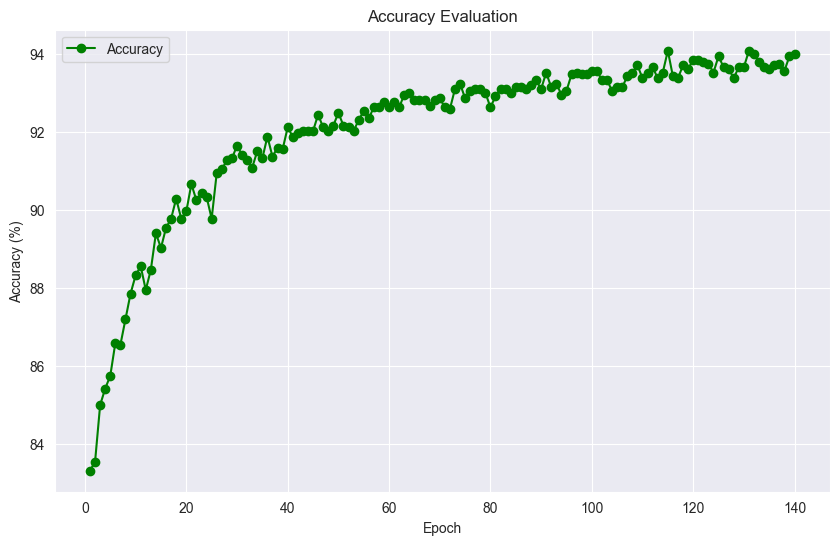

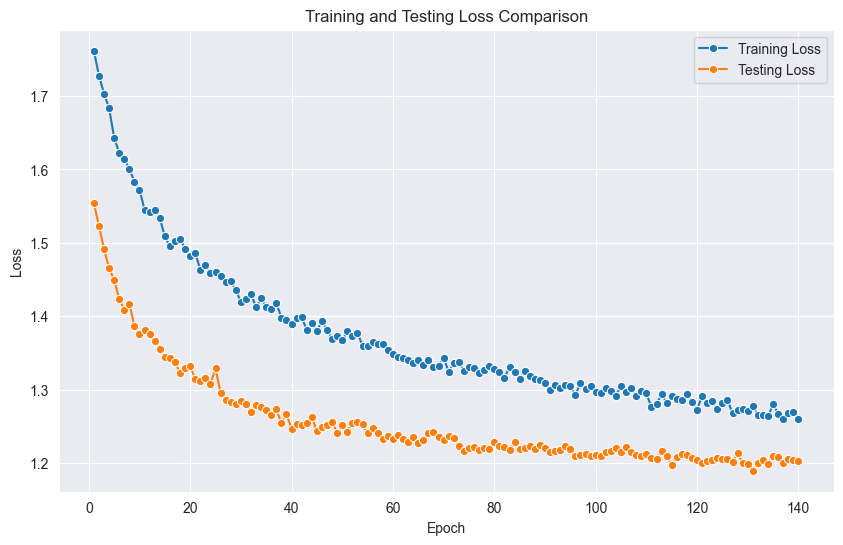

Creating new historical data...
Historical data saved successfully!


In [46]:
import torch.optim as optim

hardware = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = 6
weight_decay = 1e-2
learning_rate = 1e-4
num_margin = 3
criterion = nn.CrossEntropyLoss()

model = PestClassifierMobileNetV2(num_classes=classes, margin=num_margin).to(hardware)
model.load_state_dict(torch.load('models/MobileNetV2/v2/Advance/MobileNetV2_rice_pest_classificationV7.pt', map_location=hardware))
model.unfreeze_last_block()
model.unfreeze_before_last_block()
model.unfreeze_third_last_inverse_residual()

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),lr=learning_rate , weight_decay=weight_decay)

result_1, accuracy_1 = train_and_test(model=model, optimizer=optimizer, criterion=criterion, train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=20, device=hardware)

model.unfreeze_fourth_last_inverse_residual()

result_2, accuracy_2 = train_and_test(model=model, optimizer=optimizer, criterion=criterion, train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=30, device=hardware)

model.unfreeze_fifth_inverse_residual()

result_3, accuracy_3 = train_and_test(model=model, optimizer=optimizer, criterion=criterion, train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=40, device=hardware)

model.unfreezing_sixth_inverse_residual()

result_4, accuracy_4 = train_and_test(model=model, optimizer=optimizer, criterion=criterion, train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=50, device=hardware)

plot_accuracy(result_1, result_2,result_3,result_4)
plot_training_result(result_1, result_2,result_3,result_4)
save_historical_data(result_1, result_2, result_3, result_4)


In [28]:
from PIL import Image

def predict_single_image(model, image_path, classes, transform, device):

    model.to(device)
    model.eval()

    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    augmented = transform(image=image_np)
    image_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        result = model(image_tensor, labels=None)

        probabilities = F.softmax(result, dim=1)

        confidence, predicted_index = torch.max(probabilities, 1)
        predicted_class = classes[predicted_index.item()]
        confidence_score = confidence.item()

    return predicted_class, confidence_score, probabilities.squeeze().cpu().numpy()


<h2> V7 training </h2>


--- Starting Training Session 1/5 ---


Test epoch: 1: 100%|██████████| 34/34 [00:07<00:00,  4.35it/s]


Epoch 1/15 | Train Loss: 3.2395 | Test Loss: 3.0162 | Accuracy: 44.32% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB


Test epoch: 2: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 2/15 | Train Loss: 3.0253 | Test Loss: 2.9890 | Accuracy: 61.35% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB


Test epoch: 3: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 3/15 | Train Loss: 2.9985 | Test Loss: 2.9704 | Accuracy: 64.63% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB


Test epoch: 4: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 4/15 | Train Loss: 2.9860 | Test Loss: 2.9573 | Accuracy: 66.04% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB


Test epoch: 5: 100%|██████████| 34/34 [00:05<00:00,  5.72it/s]


Epoch 5/15 | Train Loss: 2.9809 | Test Loss: 2.9531 | Accuracy: 67.26% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB


Test epoch: 6: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Epoch 6/15 | Train Loss: 2.9791 | Test Loss: 2.9475 | Accuracy: 67.26% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB


Test epoch: 7: 100%|██████████| 34/34 [00:05<00:00,  5.72it/s]


Epoch 7/15 | Train Loss: 2.9769 | Test Loss: 2.9468 | Accuracy: 67.03% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB


Test epoch: 8: 100%|██████████| 34/34 [00:06<00:00,  5.65it/s]


Epoch 8/15 | Train Loss: 2.9768 | Test Loss: 2.9478 | Accuracy: 68.15% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB


Test epoch: 9: 100%|██████████| 34/34 [00:06<00:00,  5.63it/s]


Epoch 9/15 | Train Loss: 2.9768 | Test Loss: 2.9449 | Accuracy: 67.96% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB


Test epoch: 10: 100%|██████████| 34/34 [00:06<00:00,  5.66it/s]


Epoch 10/15 | Train Loss: 2.9758 | Test Loss: 2.9469 | Accuracy: 68.01% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB


Test epoch: 11: 100%|██████████| 34/34 [00:12<00:00,  2.63it/s]


Epoch 11/15 | Train Loss: 2.9760 | Test Loss: 2.9456 | Accuracy: 67.82% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB


Test epoch: 12: 100%|██████████| 34/34 [00:13<00:00,  2.59it/s]


Epoch 12/15 | Train Loss: 2.9765 | Test Loss: 2.9491 | Accuracy: 67.31% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB


Test epoch: 13: 100%|██████████| 34/34 [00:06<00:00,  5.36it/s]


Epoch 13/15 | Train Loss: 2.9776 | Test Loss: 2.9471 | Accuracy: 67.35% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB


Test epoch: 14: 100%|██████████| 34/34 [00:06<00:00,  5.41it/s]


Epoch 14/15 | Train Loss: 2.9750 | Test Loss: 2.9476 | Accuracy: 67.78% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB


Test epoch: 15: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Epoch 15/15 | Train Loss: 2.9771 | Test Loss: 2.9465 | Accuracy: 67.68% | GPU Memory (Alloc/Reserved): 0.06/1.82 GB
Phase done!

--- Starting Training Session 2/5 ---

Unfreezing feature layer at index: -1


Test epoch: 1: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch 1/25 | Train Loss: 2.9715 | Test Loss: 2.9318 | Accuracy: 70.64% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 2: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch 2/25 | Train Loss: 2.9606 | Test Loss: 2.9185 | Accuracy: 72.42% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 3: 100%|██████████| 34/34 [00:06<00:00,  5.51it/s]


Epoch 3/25 | Train Loss: 2.9504 | Test Loss: 2.9036 | Accuracy: 74.02% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 4: 100%|██████████| 34/34 [00:06<00:00,  5.51it/s]


Epoch 4/25 | Train Loss: 2.9395 | Test Loss: 2.8881 | Accuracy: 75.47% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 5: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch 5/25 | Train Loss: 2.9313 | Test Loss: 2.8682 | Accuracy: 76.13% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 6: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]


Epoch 6/25 | Train Loss: 2.9238 | Test Loss: 2.8544 | Accuracy: 77.02% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 7: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch 7/25 | Train Loss: 2.9129 | Test Loss: 2.8363 | Accuracy: 78.10% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 8: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Epoch 8/25 | Train Loss: 2.9045 | Test Loss: 2.8155 | Accuracy: 77.95% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 9: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]


Epoch 9/25 | Train Loss: 2.8961 | Test Loss: 2.7987 | Accuracy: 78.75% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 10: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch 10/25 | Train Loss: 2.8850 | Test Loss: 2.7731 | Accuracy: 79.41% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 11: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 11/25 | Train Loss: 2.8767 | Test Loss: 2.7493 | Accuracy: 79.55% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 12: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s]


Epoch 12/25 | Train Loss: 2.8697 | Test Loss: 2.7237 | Accuracy: 79.32% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 13: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s]


Epoch 13/25 | Train Loss: 2.8579 | Test Loss: 2.6945 | Accuracy: 79.46% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 14: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s]


Epoch 14/25 | Train Loss: 2.8462 | Test Loss: 2.6646 | Accuracy: 79.32% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 15: 100%|██████████| 34/34 [00:05<00:00,  5.79it/s]


Epoch 15/25 | Train Loss: 2.8366 | Test Loss: 2.6281 | Accuracy: 78.85% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 16: 100%|██████████| 34/34 [00:05<00:00,  5.83it/s]


Epoch 16/25 | Train Loss: 2.8260 | Test Loss: 2.5989 | Accuracy: 79.08% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 17: 100%|██████████| 34/34 [00:05<00:00,  5.76it/s]


Epoch 17/25 | Train Loss: 2.8117 | Test Loss: 2.5633 | Accuracy: 78.80% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 18: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Epoch 18/25 | Train Loss: 2.8055 | Test Loss: 2.5277 | Accuracy: 78.61% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 19: 100%|██████████| 34/34 [00:06<00:00,  5.13it/s]


Epoch 19/25 | Train Loss: 2.7914 | Test Loss: 2.4894 | Accuracy: 78.28% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 20: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 20/25 | Train Loss: 2.7766 | Test Loss: 2.4535 | Accuracy: 78.33% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 21: 100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


Epoch 21/25 | Train Loss: 2.7667 | Test Loss: 2.4154 | Accuracy: 78.38% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 22: 100%|██████████| 34/34 [00:07<00:00,  4.83it/s]


Epoch 22/25 | Train Loss: 2.7521 | Test Loss: 2.3748 | Accuracy: 78.33% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 23: 100%|██████████| 34/34 [00:07<00:00,  4.57it/s]


Epoch 23/25 | Train Loss: 2.7393 | Test Loss: 2.3381 | Accuracy: 78.42% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 24: 100%|██████████| 34/34 [00:06<00:00,  5.17it/s]


Epoch 24/25 | Train Loss: 2.7320 | Test Loss: 2.3006 | Accuracy: 78.05% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 25: 100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


Epoch 25/25 | Train Loss: 2.7168 | Test Loss: 2.2705 | Accuracy: 77.86% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB
Phase done!

--- Starting Training Session 3/5 ---

Unfreezing feature layer at index: -2


Test epoch: 1: 100%|██████████| 34/34 [00:06<00:00,  5.33it/s]


Epoch 1/35 | Train Loss: 2.6759 | Test Loss: 2.1249 | Accuracy: 77.95% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 2: 100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


Epoch 2/35 | Train Loss: 2.6215 | Test Loss: 2.0183 | Accuracy: 79.17% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 3: 100%|██████████| 34/34 [00:06<00:00,  5.66it/s]


Epoch 3/35 | Train Loss: 2.5727 | Test Loss: 1.9290 | Accuracy: 80.35% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 4: 100%|██████████| 34/34 [00:06<00:00,  5.51it/s]


Epoch 4/35 | Train Loss: 2.5398 | Test Loss: 1.8540 | Accuracy: 81.10% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 5: 100%|██████████| 34/34 [00:07<00:00,  4.54it/s]


Epoch 5/35 | Train Loss: 2.4977 | Test Loss: 1.7979 | Accuracy: 82.36% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 6: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 6/35 | Train Loss: 2.4675 | Test Loss: 1.7597 | Accuracy: 82.55% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 7: 100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


Epoch 7/35 | Train Loss: 2.4477 | Test Loss: 1.7187 | Accuracy: 83.86% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 8: 100%|██████████| 34/34 [00:06<00:00,  5.45it/s]


Epoch 8/35 | Train Loss: 2.4237 | Test Loss: 1.6808 | Accuracy: 84.62% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 9: 100%|██████████| 34/34 [00:06<00:00,  5.38it/s]


Epoch 9/35 | Train Loss: 2.4069 | Test Loss: 1.6466 | Accuracy: 85.65% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 10: 100%|██████████| 34/34 [00:06<00:00,  5.44it/s]


Epoch 10/35 | Train Loss: 2.3864 | Test Loss: 1.6190 | Accuracy: 86.26% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 11: 100%|██████████| 34/34 [00:06<00:00,  5.03it/s]


Epoch 11/35 | Train Loss: 2.3656 | Test Loss: 1.5904 | Accuracy: 86.77% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 12: 100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


Epoch 12/35 | Train Loss: 2.3476 | Test Loss: 1.5653 | Accuracy: 86.96% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 13: 100%|██████████| 34/34 [00:05<00:00,  5.71it/s]


Epoch 13/35 | Train Loss: 2.3345 | Test Loss: 1.5406 | Accuracy: 87.38% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 14: 100%|██████████| 34/34 [00:06<00:00,  5.66it/s]


Epoch 14/35 | Train Loss: 2.3249 | Test Loss: 1.5145 | Accuracy: 87.57% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 15: 100%|██████████| 34/34 [00:05<00:00,  5.71it/s]


Epoch 15/35 | Train Loss: 2.3034 | Test Loss: 1.4934 | Accuracy: 87.62% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 16: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 16/35 | Train Loss: 2.2914 | Test Loss: 1.4711 | Accuracy: 88.41% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 17: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch 17/35 | Train Loss: 2.2902 | Test Loss: 1.4584 | Accuracy: 88.09% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 18: 100%|██████████| 34/34 [00:05<00:00,  5.71it/s]


Epoch 18/35 | Train Loss: 2.2714 | Test Loss: 1.4394 | Accuracy: 89.02% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 19: 100%|██████████| 34/34 [00:05<00:00,  5.79it/s]


Epoch 19/35 | Train Loss: 2.2620 | Test Loss: 1.4294 | Accuracy: 88.84% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 20: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch 20/35 | Train Loss: 2.2520 | Test Loss: 1.4182 | Accuracy: 89.07% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 21: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 21/35 | Train Loss: 2.2493 | Test Loss: 1.4078 | Accuracy: 88.84% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 22: 100%|██████████| 34/34 [00:05<00:00,  5.76it/s]


Epoch 22/35 | Train Loss: 2.2384 | Test Loss: 1.3965 | Accuracy: 89.54% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 23: 100%|██████████| 34/34 [00:06<00:00,  5.50it/s]


Epoch 23/35 | Train Loss: 2.2327 | Test Loss: 1.3927 | Accuracy: 89.35% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 24: 100%|██████████| 34/34 [00:05<00:00,  5.68it/s]


Epoch 24/35 | Train Loss: 2.2300 | Test Loss: 1.3818 | Accuracy: 89.40% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 25: 100%|██████████| 34/34 [00:05<00:00,  5.68it/s]


Epoch 25/35 | Train Loss: 2.2294 | Test Loss: 1.3754 | Accuracy: 89.82% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 26: 100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


Epoch 26/35 | Train Loss: 2.2128 | Test Loss: 1.3677 | Accuracy: 89.73% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 27: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Epoch 27/35 | Train Loss: 2.2133 | Test Loss: 1.3589 | Accuracy: 89.54% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 28: 100%|██████████| 34/34 [00:05<00:00,  5.70it/s]


Epoch 28/35 | Train Loss: 2.2057 | Test Loss: 1.3517 | Accuracy: 89.92% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 29: 100%|██████████| 34/34 [00:05<00:00,  5.67it/s]


Epoch 29/35 | Train Loss: 2.2143 | Test Loss: 1.3513 | Accuracy: 89.92% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 30: 100%|██████████| 34/34 [00:05<00:00,  5.68it/s]


Epoch 30/35 | Train Loss: 2.2039 | Test Loss: 1.3490 | Accuracy: 90.01% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 31: 100%|██████████| 34/34 [00:06<00:00,  5.67it/s]


Epoch 31/35 | Train Loss: 2.1963 | Test Loss: 1.3326 | Accuracy: 90.29% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 32: 100%|██████████| 34/34 [00:12<00:00,  2.83it/s]


Epoch 32/35 | Train Loss: 2.1910 | Test Loss: 1.3373 | Accuracy: 90.43% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 33: 100%|██████████| 34/34 [00:11<00:00,  3.05it/s]


Epoch 33/35 | Train Loss: 2.1821 | Test Loss: 1.3291 | Accuracy: 90.15% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 34: 100%|██████████| 34/34 [00:10<00:00,  3.25it/s]


Epoch 34/35 | Train Loss: 2.1885 | Test Loss: 1.3304 | Accuracy: 90.62% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 35: 100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch 35/35 | Train Loss: 2.1855 | Test Loss: 1.3171 | Accuracy: 90.62% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB
Phase done!

--- Starting Training Session 4/5 ---

Unfreezing feature layer at index: -3


Test epoch: 1: 100%|██████████| 34/34 [00:11<00:00,  2.93it/s]


Epoch 1/45 | Train Loss: 2.1842 | Test Loss: 1.3132 | Accuracy: 90.62% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 2: 100%|██████████| 34/34 [00:07<00:00,  4.39it/s]


Epoch 2/45 | Train Loss: 2.1768 | Test Loss: 1.3083 | Accuracy: 90.76% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 3: 100%|██████████| 34/34 [00:12<00:00,  2.82it/s]


Epoch 3/45 | Train Loss: 2.1553 | Test Loss: 1.2968 | Accuracy: 91.23% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 4: 100%|██████████| 34/34 [00:10<00:00,  3.22it/s]


Epoch 4/45 | Train Loss: 2.1597 | Test Loss: 1.2934 | Accuracy: 91.37% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 5: 100%|██████████| 34/34 [00:11<00:00,  3.04it/s]


Epoch 5/45 | Train Loss: 2.1553 | Test Loss: 1.2953 | Accuracy: 91.28% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 6: 100%|██████████| 34/34 [00:10<00:00,  3.19it/s]


Epoch 6/45 | Train Loss: 2.1409 | Test Loss: 1.2929 | Accuracy: 91.65% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 7: 100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


Epoch 7/45 | Train Loss: 2.1491 | Test Loss: 1.2806 | Accuracy: 91.70% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 8: 100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


Epoch 8/45 | Train Loss: 2.1419 | Test Loss: 1.2835 | Accuracy: 91.46% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 9: 100%|██████████| 34/34 [00:11<00:00,  3.07it/s]


Epoch 9/45 | Train Loss: 2.1373 | Test Loss: 1.2779 | Accuracy: 91.42% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 10: 100%|██████████| 34/34 [00:11<00:00,  2.86it/s]


Epoch 10/45 | Train Loss: 2.1323 | Test Loss: 1.2779 | Accuracy: 92.17% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 11: 100%|██████████| 34/34 [00:10<00:00,  3.33it/s]


Epoch 11/45 | Train Loss: 2.1358 | Test Loss: 1.2734 | Accuracy: 91.93% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 12: 100%|██████████| 34/34 [00:10<00:00,  3.35it/s]


Epoch 12/45 | Train Loss: 2.1330 | Test Loss: 1.2702 | Accuracy: 92.07% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 13: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 13/45 | Train Loss: 2.1268 | Test Loss: 1.2598 | Accuracy: 92.17% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 14: 100%|██████████| 34/34 [00:10<00:00,  3.23it/s]


Epoch 14/45 | Train Loss: 2.1200 | Test Loss: 1.2633 | Accuracy: 92.12% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 15: 100%|██████████| 34/34 [00:10<00:00,  3.24it/s]


Epoch 15/45 | Train Loss: 2.1180 | Test Loss: 1.2629 | Accuracy: 91.84% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 16: 100%|██████████| 34/34 [00:07<00:00,  4.67it/s]


Epoch 16/45 | Train Loss: 2.1143 | Test Loss: 1.2590 | Accuracy: 92.07% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 17: 100%|██████████| 34/34 [00:11<00:00,  2.92it/s]


Epoch 17/45 | Train Loss: 2.1146 | Test Loss: 1.2541 | Accuracy: 92.21% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 18: 100%|██████████| 34/34 [00:10<00:00,  3.16it/s]


Epoch 18/45 | Train Loss: 2.1093 | Test Loss: 1.2566 | Accuracy: 92.17% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 19: 100%|██████████| 34/34 [00:10<00:00,  3.23it/s]


Epoch 19/45 | Train Loss: 2.1123 | Test Loss: 1.2527 | Accuracy: 92.35% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 20: 100%|██████████| 34/34 [00:11<00:00,  2.99it/s]


Epoch 20/45 | Train Loss: 2.0996 | Test Loss: 1.2505 | Accuracy: 92.31% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 21: 100%|██████████| 34/34 [00:11<00:00,  2.96it/s]


Epoch 21/45 | Train Loss: 2.1025 | Test Loss: 1.2440 | Accuracy: 92.92% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 22: 100%|██████████| 34/34 [00:10<00:00,  3.29it/s]


Epoch 22/45 | Train Loss: 2.1039 | Test Loss: 1.2477 | Accuracy: 92.17% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 23: 100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


Epoch 23/45 | Train Loss: 2.1013 | Test Loss: 1.2494 | Accuracy: 92.35% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 24: 100%|██████████| 34/34 [00:06<00:00,  5.16it/s]


Epoch 24/45 | Train Loss: 2.0947 | Test Loss: 1.2402 | Accuracy: 93.01% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 25: 100%|██████████| 34/34 [00:11<00:00,  2.99it/s]


Epoch 25/45 | Train Loss: 2.0918 | Test Loss: 1.2424 | Accuracy: 92.64% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 26: 100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch 26/45 | Train Loss: 2.0935 | Test Loss: 1.2424 | Accuracy: 92.68% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 27: 100%|██████████| 34/34 [00:12<00:00,  2.78it/s]


Epoch 27/45 | Train Loss: 2.0939 | Test Loss: 1.2426 | Accuracy: 92.59% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 28: 100%|██████████| 34/34 [00:10<00:00,  3.16it/s]


Epoch 28/45 | Train Loss: 2.0944 | Test Loss: 1.2417 | Accuracy: 92.68% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 29: 100%|██████████| 34/34 [00:11<00:00,  3.06it/s]


Epoch 29/45 | Train Loss: 2.0944 | Test Loss: 1.2340 | Accuracy: 93.29% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 30: 100%|██████████| 34/34 [00:12<00:00,  2.78it/s]


Epoch 30/45 | Train Loss: 2.0858 | Test Loss: 1.2311 | Accuracy: 93.11% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 31: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Epoch 31/45 | Train Loss: 2.0894 | Test Loss: 1.2385 | Accuracy: 93.06% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 32: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 32/45 | Train Loss: 2.0822 | Test Loss: 1.2334 | Accuracy: 92.96% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 33: 100%|██████████| 34/34 [00:11<00:00,  2.84it/s]


Epoch 33/45 | Train Loss: 2.0822 | Test Loss: 1.2284 | Accuracy: 93.06% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 34: 100%|██████████| 34/34 [00:12<00:00,  2.78it/s]


Epoch 34/45 | Train Loss: 2.0872 | Test Loss: 1.2229 | Accuracy: 93.25% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 35: 100%|██████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 35/45 | Train Loss: 2.0816 | Test Loss: 1.2282 | Accuracy: 93.06% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 36: 100%|██████████| 34/34 [00:10<00:00,  3.19it/s]


Epoch 36/45 | Train Loss: 2.0727 | Test Loss: 1.2263 | Accuracy: 93.25% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 37: 100%|██████████| 34/34 [00:11<00:00,  2.86it/s]


Epoch 37/45 | Train Loss: 2.0764 | Test Loss: 1.2294 | Accuracy: 92.96% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 38: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 38/45 | Train Loss: 2.0802 | Test Loss: 1.2239 | Accuracy: 93.39% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 39: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 39/45 | Train Loss: 2.0670 | Test Loss: 1.2277 | Accuracy: 93.11% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 40: 100%|██████████| 34/34 [00:12<00:00,  2.76it/s]


Epoch 40/45 | Train Loss: 2.0696 | Test Loss: 1.2260 | Accuracy: 93.29% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 41: 100%|██████████| 34/34 [00:10<00:00,  3.10it/s]


Epoch 41/45 | Train Loss: 2.0622 | Test Loss: 1.2195 | Accuracy: 93.39% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 42: 100%|██████████| 34/34 [00:10<00:00,  3.26it/s]


Epoch 42/45 | Train Loss: 2.0672 | Test Loss: 1.2205 | Accuracy: 93.25% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 43: 100%|██████████| 34/34 [00:10<00:00,  3.37it/s]


Epoch 43/45 | Train Loss: 2.0710 | Test Loss: 1.2222 | Accuracy: 93.81% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 44: 100%|██████████| 34/34 [00:11<00:00,  3.01it/s]


Epoch 44/45 | Train Loss: 2.0690 | Test Loss: 1.2179 | Accuracy: 93.67% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB


Test epoch: 45: 100%|██████████| 34/34 [00:11<00:00,  2.89it/s]


Epoch 45/45 | Train Loss: 2.0621 | Test Loss: 1.2174 | Accuracy: 93.53% | GPU Memory (Alloc/Reserved): 0.07/1.83 GB
Phase done!

--- Starting Training Session 5/5 ---

Unfreezing feature layer at index: -4


Test epoch: 1: 100%|██████████| 34/34 [00:10<00:00,  3.31it/s]


Epoch 1/55 | Train Loss: 2.0740 | Test Loss: 1.2228 | Accuracy: 93.48% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 2: 100%|██████████| 34/34 [00:11<00:00,  2.96it/s]


Epoch 2/55 | Train Loss: 2.0659 | Test Loss: 1.2175 | Accuracy: 93.48% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 3: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]


Epoch 3/55 | Train Loss: 2.0662 | Test Loss: 1.2247 | Accuracy: 93.76% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 4: 100%|██████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch 4/55 | Train Loss: 2.0633 | Test Loss: 1.2189 | Accuracy: 93.62% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 5: 100%|██████████| 34/34 [00:10<00:00,  3.25it/s]


Epoch 5/55 | Train Loss: 2.0522 | Test Loss: 1.2205 | Accuracy: 93.76% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 6: 100%|██████████| 34/34 [00:11<00:00,  2.96it/s]


Epoch 6/55 | Train Loss: 2.0599 | Test Loss: 1.2133 | Accuracy: 93.62% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 7: 100%|██████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 7/55 | Train Loss: 2.0517 | Test Loss: 1.2097 | Accuracy: 93.90% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 8: 100%|██████████| 34/34 [00:10<00:00,  3.28it/s]


Epoch 8/55 | Train Loss: 2.0621 | Test Loss: 1.2111 | Accuracy: 93.62% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 9: 100%|██████████| 34/34 [00:10<00:00,  3.37it/s]


Epoch 9/55 | Train Loss: 2.0545 | Test Loss: 1.2121 | Accuracy: 93.29% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 10: 100%|██████████| 34/34 [00:11<00:00,  2.96it/s]


Epoch 10/55 | Train Loss: 2.0558 | Test Loss: 1.2167 | Accuracy: 93.34% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 11: 100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


Epoch 11/55 | Train Loss: 2.0626 | Test Loss: 1.2138 | Accuracy: 93.48% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 12: 100%|██████████| 34/34 [00:05<00:00,  5.76it/s]


Epoch 12/55 | Train Loss: 2.0501 | Test Loss: 1.2196 | Accuracy: 93.62% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 13: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 13/55 | Train Loss: 2.0533 | Test Loss: 1.2148 | Accuracy: 93.71% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 14: 100%|██████████| 34/34 [00:11<00:00,  2.95it/s]


Epoch 14/55 | Train Loss: 2.0465 | Test Loss: 1.2118 | Accuracy: 93.76% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 15: 100%|██████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 15/55 | Train Loss: 2.0419 | Test Loss: 1.2125 | Accuracy: 93.90% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 16: 100%|██████████| 34/34 [00:10<00:00,  3.29it/s]


Epoch 16/55 | Train Loss: 2.0496 | Test Loss: 1.2119 | Accuracy: 93.76% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 17: 100%|██████████| 34/34 [00:09<00:00,  3.44it/s]


Epoch 17/55 | Train Loss: 2.0347 | Test Loss: 1.2043 | Accuracy: 93.86% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 18: 100%|██████████| 34/34 [00:12<00:00,  2.78it/s]


Epoch 18/55 | Train Loss: 2.0402 | Test Loss: 1.2033 | Accuracy: 93.67% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 19: 100%|██████████| 34/34 [00:10<00:00,  3.09it/s]


Epoch 19/55 | Train Loss: 2.0398 | Test Loss: 1.2058 | Accuracy: 93.95% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 20: 100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


Epoch 20/55 | Train Loss: 2.0439 | Test Loss: 1.2106 | Accuracy: 93.81% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 21: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 21/55 | Train Loss: 2.0366 | Test Loss: 1.1994 | Accuracy: 94.00% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 22: 100%|██████████| 34/34 [00:11<00:00,  3.02it/s]


Epoch 22/55 | Train Loss: 2.0415 | Test Loss: 1.1965 | Accuracy: 94.14% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 23: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch 23/55 | Train Loss: 2.0297 | Test Loss: 1.2043 | Accuracy: 94.00% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 24: 100%|██████████| 34/34 [00:10<00:00,  3.19it/s]


Epoch 24/55 | Train Loss: 2.0326 | Test Loss: 1.1993 | Accuracy: 94.18% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 25: 100%|██████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 25/55 | Train Loss: 2.0408 | Test Loss: 1.1940 | Accuracy: 94.32% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 26: 100%|██████████| 34/34 [00:11<00:00,  2.95it/s]


Epoch 26/55 | Train Loss: 2.0279 | Test Loss: 1.1973 | Accuracy: 94.14% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 27: 100%|██████████| 34/34 [00:11<00:00,  2.87it/s]


Epoch 27/55 | Train Loss: 2.0385 | Test Loss: 1.1992 | Accuracy: 94.09% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 28: 100%|██████████| 34/34 [00:10<00:00,  3.28it/s]


Epoch 28/55 | Train Loss: 2.0275 | Test Loss: 1.2001 | Accuracy: 93.95% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 29: 100%|██████████| 34/34 [00:10<00:00,  3.35it/s]


Epoch 29/55 | Train Loss: 2.0321 | Test Loss: 1.1914 | Accuracy: 94.23% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 30: 100%|██████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 30/55 | Train Loss: 2.0311 | Test Loss: 1.1903 | Accuracy: 94.18% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 31: 100%|██████████| 34/34 [00:10<00:00,  3.20it/s]


Epoch 31/55 | Train Loss: 2.0218 | Test Loss: 1.2011 | Accuracy: 94.28% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 32: 100%|██████████| 34/34 [00:10<00:00,  3.24it/s]


Epoch 32/55 | Train Loss: 2.0259 | Test Loss: 1.2024 | Accuracy: 94.42% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 33: 100%|██████████| 34/34 [00:11<00:00,  2.85it/s]


Epoch 33/55 | Train Loss: 2.0267 | Test Loss: 1.1924 | Accuracy: 94.18% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 34: 100%|██████████| 34/34 [00:11<00:00,  3.05it/s]


Epoch 34/55 | Train Loss: 2.0265 | Test Loss: 1.1959 | Accuracy: 94.37% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 35: 100%|██████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 35/55 | Train Loss: 2.0268 | Test Loss: 1.1939 | Accuracy: 93.95% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 36: 100%|██████████| 34/34 [00:05<00:00,  5.70it/s]


Epoch 36/55 | Train Loss: 2.0237 | Test Loss: 1.1887 | Accuracy: 94.18% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 37: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s]


Epoch 37/55 | Train Loss: 2.0218 | Test Loss: 1.2004 | Accuracy: 94.37% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 38: 100%|██████████| 34/34 [00:06<00:00,  5.40it/s]


Epoch 38/55 | Train Loss: 2.0277 | Test Loss: 1.1941 | Accuracy: 94.47% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 39: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]


Epoch 39/55 | Train Loss: 2.0183 | Test Loss: 1.1869 | Accuracy: 94.23% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 40: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]


Epoch 40/55 | Train Loss: 2.0197 | Test Loss: 1.1907 | Accuracy: 94.42% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 41: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s]


Epoch 41/55 | Train Loss: 2.0212 | Test Loss: 1.1845 | Accuracy: 94.32% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 42: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch 42/55 | Train Loss: 2.0220 | Test Loss: 1.1889 | Accuracy: 94.47% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 43: 100%|██████████| 34/34 [00:06<00:00,  5.47it/s]


Epoch 43/55 | Train Loss: 2.0172 | Test Loss: 1.1942 | Accuracy: 94.32% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 44: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 44/55 | Train Loss: 2.0146 | Test Loss: 1.1822 | Accuracy: 94.37% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 45: 100%|██████████| 34/34 [00:11<00:00,  2.91it/s]


Epoch 45/55 | Train Loss: 2.0178 | Test Loss: 1.1843 | Accuracy: 94.61% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 46: 100%|██████████| 34/34 [00:11<00:00,  3.04it/s]


Epoch 46/55 | Train Loss: 2.0181 | Test Loss: 1.1886 | Accuracy: 94.61% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 47: 100%|██████████| 34/34 [00:10<00:00,  3.27it/s]


Epoch 47/55 | Train Loss: 2.0202 | Test Loss: 1.1911 | Accuracy: 94.32% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 48: 100%|██████████| 34/34 [00:12<00:00,  2.83it/s]


Epoch 48/55 | Train Loss: 2.0158 | Test Loss: 1.1938 | Accuracy: 94.47% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 49: 100%|██████████| 34/34 [00:05<00:00,  5.71it/s]


Epoch 49/55 | Train Loss: 2.0162 | Test Loss: 1.1835 | Accuracy: 94.42% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 50: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 50/55 | Train Loss: 2.0182 | Test Loss: 1.1948 | Accuracy: 94.32% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 51: 100%|██████████| 34/34 [00:06<00:00,  5.17it/s]


Epoch 51/55 | Train Loss: 2.0248 | Test Loss: 1.1895 | Accuracy: 94.47% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 52: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch 52/55 | Train Loss: 2.0124 | Test Loss: 1.1929 | Accuracy: 94.28% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 53: 100%|██████████| 34/34 [00:07<00:00,  4.58it/s]


Epoch 53/55 | Train Loss: 2.0093 | Test Loss: 1.1855 | Accuracy: 94.51% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 54: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 54/55 | Train Loss: 2.0095 | Test Loss: 1.1771 | Accuracy: 94.93% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB


Test epoch: 55: 100%|██████████| 34/34 [00:06<00:00,  5.03it/s]


Epoch 55/55 | Train Loss: 2.0104 | Test Loss: 1.1931 | Accuracy: 94.70% | GPU Memory (Alloc/Reserved): 0.08/1.83 GB
Phase done!


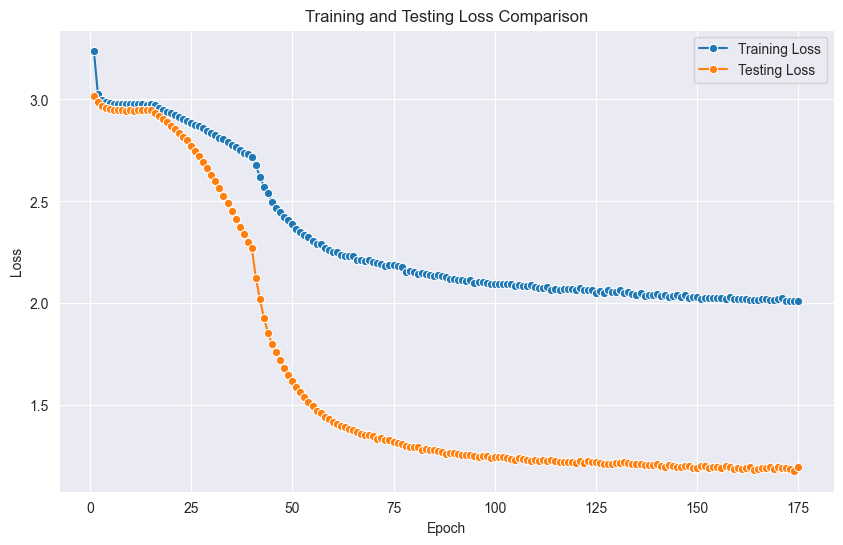

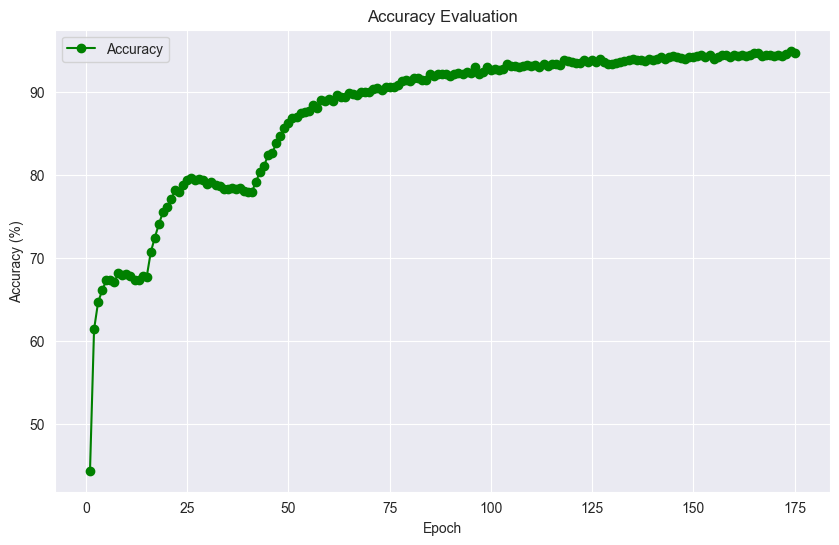

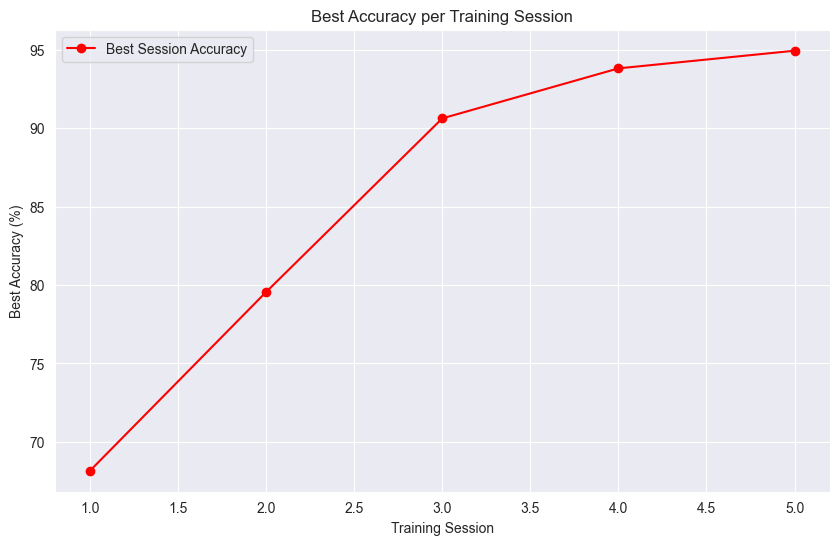

Creating new historical data...
Historical data saved successfully!


In [18]:
import torch.optim as optim

hardware = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 6
num_margin = 3
criterion = nn.CrossEntropyLoss()

model_inference = PestClassifierMobileNetV2(num_classes=num_classes, margin=num_margin).to(hardware)

training_sessions = [
    {'epochs': 15, 'lr': 1e-3, 'unfreeze_layer': 0},
    {'epochs': 25, 'lr': 1e-4, 'unfreeze_layer': 1},
    {'epochs': 35, 'lr': 1e-4, 'unfreeze_layer': 2},
    {'epochs': 45, 'lr': 1e-4, 'unfreeze_layer': 3},
    {'epochs': 55, 'lr': 1e-4, 'unfreeze_layer': 4},
]

result, accuracies = incremental_training(model=model_inference, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, test_dataloader=test_loader, device=hardware)

plot_training_result(*result)
plot_accuracy(*result)
plot_accuracy_per_session(accuracies)
save_historical_data(*result)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def eval_metrics(model, testLoader, classes_names, device):

    model.to(device)
    model.eval()

    total_predictions = []
    true_labels = []

    with torch.no_grad():

        for input, labels in tqdm(testLoader):
            input, labels = input.to(device), labels.to(device)

            output = model(input, labels=None)
            _, predicted = torch.max(output, 1)

            total_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())


    y_true = np.array(true_labels)
    y_pred = np.array(total_predictions)

    print('Classification Report')
    report = classification_report(y_true, y_pred, target_names=classes_names)

    print(report)

    print(f"\nAccuracy: {accuracy_score(y_true, y_pred)*100:.2f}%\n")

    print('Confusion Matrix')

    matrix = confusion_matrix(y_true, y_pred)

    cm_df = pd.DataFrame(matrix, index=classes_names, columns=classes_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual pests')
    plt.xlabel('Predicted pests')
    plt.show()

    return y_true, y_pred

def save_evalution_result(total_predictions, true_labels):

    data = pd.DataFrame({
        'True Labels': true_labels,
        'Predicted Labels': total_predictions
    })

    data.to_csv('evalution_result.csv', index=False)


In [22]:
y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.50      1.00      0.67         1
     class 1       0.00      0.00      0.00         1
     class 2       1.00      0.67      0.80         3

    accuracy                           0.60         5
   macro avg       0.50      0.56      0.49         5
weighted avg       0.70      0.60      0.61         5



<h2> Prediction comparison </h2>

In [61]:
import torchvision.models as models

classes_names = train_set.classes
hardware = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_inference = PestClassifierMobileNetV2(num_classes=len(classes_names), margin=4)
model_inference.load_state_dict(torch.load('models/MobileNetV2/v2/Advance/MobileNetV2_rice_pest_classificationV5.pt', map_location=hardware))
image_path =  'unrelated_data/505539566_1652348148735403_5558773441732726122_n.jpg'

pest, confidence_score, all_scores = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Confidence scores: {all_scores}")


true, pred = eval_metrics(model_inference, validation_loader, classes_names, hardware)
#
# save_evalution_result(true, pred)

TypeError: PestClassifierMobileNetV2.__init__() missing 1 required positional argument: 'margin'

In [79]:
import torchvision.models as models

classes_names = train_set.classes
hardware = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_inference = PestClassifierMobileNetV2(num_classes=len(classes_names), margin=3)
model_inference.load_state_dict(torch.load('models/MobileNetV2/v2/Advance/MobileNetV2_rice_pest_classificationV7.pt', map_location=hardware))
image_unrelated =  'unrelated_data/sample4.jpg'
image_path = 'datasets/val/rice-leaf-folder/lfolder--104-_jpg.rf.82b4fc250470271f7ed5447c5b6063f0.jpg'

pest, confidence_score, all_scores = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Confidence scores: {all_scores}")

# true, pred = eval_metrics(model_inference, validation_loader, classes_names, hardware)


The predicted pest is: rice-leaf-folder
Confidence: 37.67%
Confidence scores: [0.13622408 0.13518652 0.08422329 0.37667823 0.13506818 0.13261974]


In [19]:
import torchvision.models as models

classes_names = train_set.classes
hardware = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_inference = PestClassifierMobileNetV2(num_classes=len(classes_names), margin=3)
model_inference.load_state_dict(torch.load('selected_models/MobileNetV2_rice_pest_classificationV6.pt', map_location=hardware))
image_unrelated =  'unrelated_data/sample4.jpg'
image_path = 'datasets/val/rice-leaf-folder/LEAF-FOLDERS_original_lfolder--285--jpg_4ab803f9-80b5-44df-bd43-e77eeb197796_jpg.rf.51233b8902d176d5d53403fad3564412.jpg'

pest, confidence_score, all_scores = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Confidence scores: {all_scores}")

true, pred = eval_metrics(model_inference, validation_loader, classes_names, hardware)


The predicted pest is: rice-leaf-folder
Confidence: 37.51%
Confidence scores: [0.13622092 0.13633494 0.08293689 0.37509054 0.1363072  0.13310951]


NameError: name 'eval_metrics' is not defined

In [93]:
model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

# # print(model.classifier[1])
# print(model.features[-1])
# print("qweqwe")
# print(model.features[-2])
# print("asdasd")

print(len(model.features))

19
